# E207 HW6
### Partners: Rafael Burger, Alec Candidato
#### Time Spent: 
Rafael: _______
Alec:   _______

In [436]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
from librosa.sequence import viterbi

### In this problem, we will apply probability and statistics to do state estimation on a robot. 

### Part 1(a)

We will program our robot to move according to a Markov chain. There are 11 positions, x = 0, 1, 2, ... 10.
- Positions 0 & 10: 
    - Robot stays in place (P = 0.9)
    - Robot moves away from boundary    (P = 0.1)
- Positions 1, 2, ... 9: 
    - Robot stays in place              (P = 0.8)
    - Robot moves left                  (P = 0.1)
    - Robot moves right                 (P = 0.1)

The following code creates the state transition matrix A and prints its values. 

In [437]:
NUM_POS = 11
A = np.zeros((NUM_POS, NUM_POS))

A[0,0:2] = [0.9,0.1] # set first row
A[10,9:] = [0.1,0.9] # set last row

for i in range(1,NUM_POS-1): # set middle rows
    A[i,i-1:i+2] = [0.1, 0.8, 0.1]

print(A)    # print state transition matrix

[[0.9 0.1 0.  0.  0.  0.  0.  0.  0.  0.  0. ]
 [0.1 0.8 0.1 0.  0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.1 0.8 0.1 0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.1 0.8 0.1 0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.1 0.8 0.1 0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.1 0.8 0.1 0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.1 0.8 0.1 0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.1 0.8 0.1 0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.  0.1 0.8 0.1 0. ]
 [0.  0.  0.  0.  0.  0.  0.  0.  0.1 0.8 0.1]
 [0.  0.  0.  0.  0.  0.  0.  0.  0.  0.1 0.9]]


### Part 1(b)

In this step, we will simulate the robot's position over 50 time steps, assuming the robot starts at x = 5 in step 0. 

In [438]:
NUM_STEPS = 50
NUM_TRIALS = 10

MOVE = 0.1          # probability of moving to the left or to the right. 
STAY = 1-2*MOVE     # probability of staying in place

simData = np.zeros((NUM_TRIALS, NUM_STEPS)) # allocate matrix for simulation data
simData[:,0] = 5                            # initialize starting positions for all trials

for trial in range(NUM_TRIALS):
    for step in range(1, NUM_STEPS):
        cur_pos = simData[trial, step-1]
        p = np.random.random() # roll die for next move

        if (cur_pos == 0):
            if p < (STAY+MOVE):
                next_pos = cur_pos
            else:
                next_pos = cur_pos+1

        elif (cur_pos == 10):
            if p < (STAY+MOVE):
                nextpos = cur_pos
            else: 
                nextpos = cur_pos-1

        else: 
            if p < MOVE:
                nextpos = cur_pos - 1
            elif p < (MOVE+STAY):
                nextpos = cur_pos
            else:
                nextpos = cur_pos + 1
        
        simData[trial, step] = nextpos

Now let's plot the results

In [400]:
def plot(y_values,  x_values = None, title = "", x_label = "", y_label = "", x_lim =None, y_lim = None, type = "plot", color=None, legend = [], ax=None):
    """Generates Plots"""
    # plt.figure()
    if ax == None:
        ax = plt.axes()
        
    if x_values is None:
        x_values = np.arange(len(y_values))

    if color is not None:
        specified_color = color
    else:
        specified_color = None

    if type == "stem":
        ax.stem(x_values, y_values, linefmt = specified_color)
    else:
        ax.plot(x_values, y_values, color = specified_color)
    
    ax.legend(legend)
    ax.set_title(title)
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)

    if y_lim is not None:
        ax.set_xlim(x_lim)
        ax.set_ylim(y_lim)

    return ax

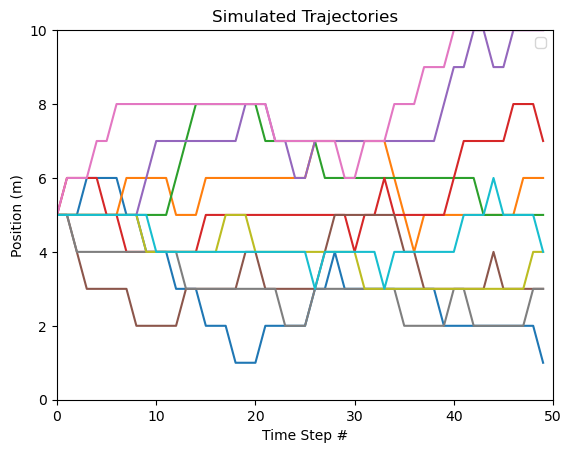

In [401]:
fig, ax1 = plt.subplots(1, 1)
for trial in range(NUM_TRIALS):
    plot(simData[trial,:], x_label = "Time Step #", y_label = "Position (m)", x_lim=(0, 50), y_lim=(0,10),title="Simulated Trajectories", ax=ax1)

### Part 1(c)

In class, we derived the following relationship between the initial state probability vector $\pi$, the state transition matrix $S$, and the probability mass function of a random variable at a time step $n$. 

$ \pi S^n = [P(S_{n+1} = 0), P(S_{n+1} = 1), P(S_{n+1} = 2), ...] $

We will use this to calculate the pmf of the robot's position at time steps 1, 2, and 3. 

In [402]:
# create initial state probability vector
pi = np.zeros(11)
pi[5] = 1

# compute pmfs
pmf1 = pi @ A
pmf2 = pi @ (np.linalg.matrix_power(A, 2)) # is there a shortcut for raising a matrix to a power? 
pmf3 = pi @ (np.linalg.matrix_power(A, 3))

Now let's plot the results. 

In [403]:
def plotPositionPMF(axis, pmf, title):
    axis.stem(pmf)
    axis.set_title(title)
    axis.set_xlabel("Position (m)")

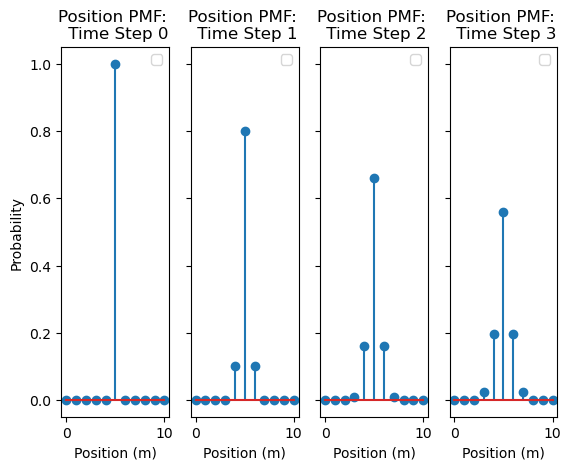

In [404]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1,4, sharey = True)

plot(pi, x_label = "Position (m)", y_label = "Probability", title="Position PMF: \n Time Step 0", ax=ax1, type="stem")
plot(pmf1, x_label = "Position (m)", title="Position PMF: \n Time Step 1", ax=ax2, type="stem")
plot(pmf2, x_label = "Position (m)", title="Position PMF: \n Time Step 2", ax=ax3, type="stem")
plot(pmf3, x_label = "Position (m)", title="Position PMF: \n Time Step 3", ax=ax4, type="stem")

plt.show()

### Part 1(d)

In this part, we will determine the time step during which the robot's position has reached a steady state distribution (assuming again that position = 5 in time step 0)

To accomplish this, we will compute the PMF of the robot's position in every time step for time steps n = 0, 1, 2, ... 99. We will then compute the cosine similarity between the PMF of time step i-1 and the time step i for i = 1, 2, ..., 99. When this similarity metric steady-states close to 1, we can be confident that the robot's position has reached a steady state distribution. 

In [405]:
def computeCosineSimilarity(n_time_steps, num_states, pi):
    """Computes the cosine similarity"""
    similarity = np.zeros(n_time_steps-1)
    pmf = np.zeros((n_time_steps, num_states))
    pmf[0,:] = pi
    for i in range(1,n_time_steps):
        last_pmf = pmf[i-1,:] # retrieve the pmf of the previous frame for easier use
        cur_pmf = pi @ np.linalg.matrix_power(A, i) # compute the pmf of the current frame
        pmf[i,:] = cur_pmf # store the current frame's pmf for use later
        
        similarity[i-1] = (last_pmf @ cur_pmf.T)/(np.linalg.norm(last_pmf) * np.linalg.norm(cur_pmf)) # compute and store cosine similarity

    return similarity, pmf
    

<Axes: title={'center': 'Cosine Similarity of Position PDF between frame (n-1) and (n)'}, xlabel='Time Step (n)', ylabel='Cosine Similarity'>

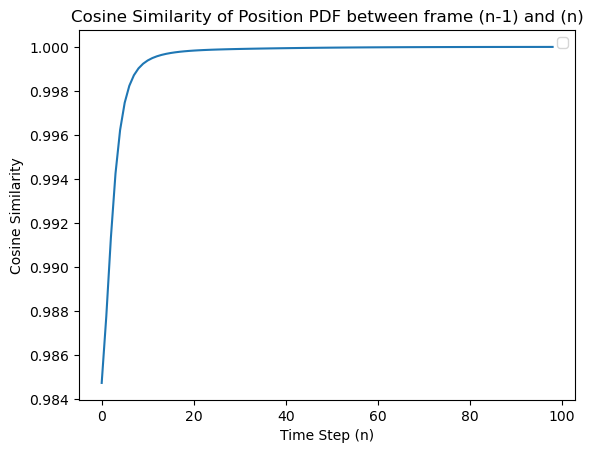

In [406]:
similarity, pmf = computeCosineSimilarity(100, 11, pi)
plot(similarity, x_label = "Time Step (n)", y_label = "Cosine Similarity", title="Cosine Similarity of Position PDF between frame (n-1) and (n)",)

These results show that the cosine similarity between frame (i-1) and frame (i) reaches its steady state of ~1 around frame 20. To check this, let's plot the PMF of frame 20 and frame 21 side by side. 

<Axes: title={'center': 'Position PMF: \nTime Step 21'}, xlabel='Position (m)'>

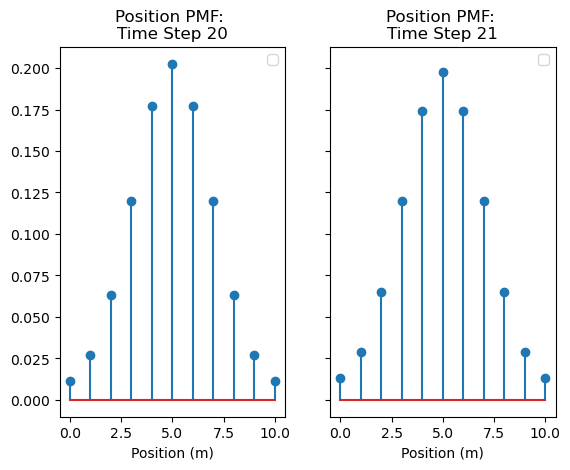

In [407]:
fig, (ax1, ax2) = plt.subplots(1,2, sharey = True)

plot(pmf[20,:], x_label = "Position (m)", title="Position PMF: \nTime Step 20", ax=ax1, type="stem")
plot(pmf[21,:], x_label = "Position (m)", title="Position PMF: \nTime Step 21", ax=ax2, type="stem")

We can tell by inspection that there is close to no variation betwen these two PMFs, so we are confident that we can consider time step 20 to correspond the time at which the robot's position reaches a steady state distribution. 

### Part 1(e)

In this section, we will simulate the effect that noisy measurements have on our observations of the robot's position. We will select one of the trajectories from part 1(b) and generate three plots of the observed lidar estimates in scenarios that simulate low, medium, and high SNR. 

In [408]:
def getObservations(x_true, var, num_obs, mu=None):
    # generate  gaussian noise samples
    # set random_state to get the "same" sample pulled from each of the test distributions
    n = multivariate_normal.rvs(mean = mu, cov = var, size = num_obs, random_state = 1) 
    x_tilde_continuous = x_true + n
    x_tilde = np.round(x_tilde_continuous, decimals = 2) # round this so we can easily convert from prob density to true probability later
    return x_tilde

<Axes: title={'center': 'True And Observed Trajectories'}, xlabel='Time Steps (n)', ylabel='Position [m]'>

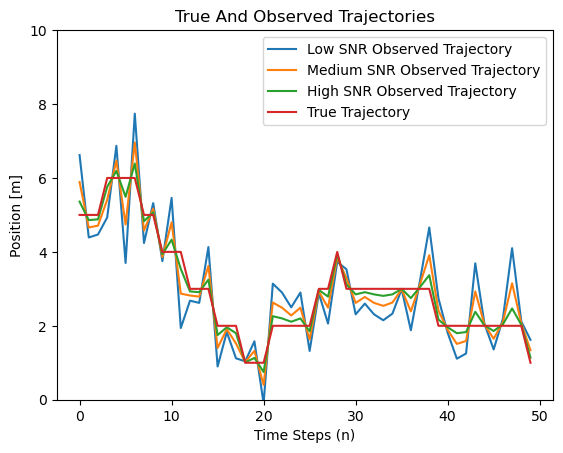

In [409]:
cov = [1, 0.3, 0.05]
x_tilde = np.zeros((3, NUM_STEPS)) # noisy data
x = simData[0,:] # original data

fig, ax1 = plt.subplots(1,1)
for i in range(3):
    x_tilde[i,:] = getObservations(x, cov[i], NUM_STEPS)
    
    plot(x_tilde[i,:], ax=ax1)

plot(x, 
     title="True And Observed Trajectories",
     legend=("Low SNR Observed Trajectory","Medium SNR Observed Trajectory","High SNR Observed Trajectory","True Trajectory"),
     y_lim=(0,10),
     x_label="Time Steps (n)",
     y_label="Position [m]",
     ax=ax1)


### Part 1(f)

In this step, we estimate the robot's position over time based on simulated noisy lidar readings. We use the Viterbi algorithm to estimate trajectories based on the three observation sets representing low, medium, and high SNR. 

In [410]:
def calc_viterbi_estimate(obs, trans, p_init, var, num_states, num_obs, multivar = False):
    p_emit = np.zeros((num_states, num_obs))

    for i in range(num_states):
        denom = np.sqrt(2*np.pi*var)
        num = np.exp(((obs-i)**2) / (-2 *var))
        p_emit[i,:] = num/denom

    p_emit = p_emit * 0.01 # multiple prob density by distance to get probability
    

    path = viterbi(p_emit, trans, p_init = p_init)
    return path

def plotViterbiEstimate(ax, x, est, title=None):
    ax.plot(x)
    ax.plot(est, 'o', color='red')
    ax.set_xlabel("Time step")
    ax.set_title(title)

In [411]:
est_lowSNR = calc_viterbi_estimate(x_tilde[0,:], A, pi, cov[0], NUM_POS, NUM_STEPS)
est_medSNR = calc_viterbi_estimate(x_tilde[1,:], A, pi, cov[1], NUM_POS, NUM_STEPS)
est_highSNR = calc_viterbi_estimate(x_tilde[2,:], A, pi, cov[2], NUM_POS, NUM_STEPS)

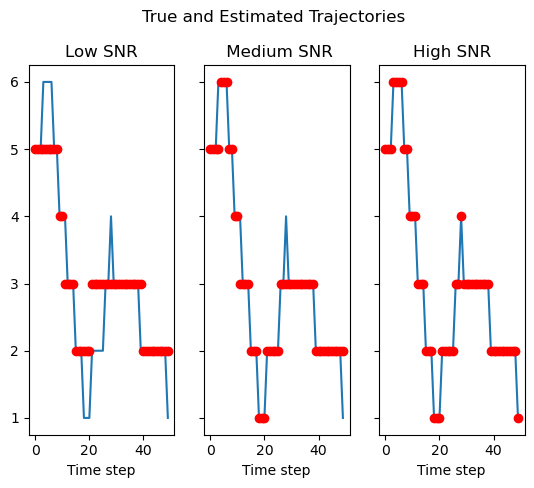

In [412]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3,sharey=True)
plotViterbiEstimate(ax1, x, est_lowSNR, "\n\nLow SNR")
plotViterbiEstimate(ax2, x, est_medSNR, "True and Estimated Trajectories \n \n Medium SNR")
plotViterbiEstimate(ax3, x, est_highSNR, "\n\nHigh SNR")

### Part 1(g)

In this step we perform the simulation from part 1(f) with a larger set of measurement noise variances $\sigma_n^2$. We compute the Viterbi estimate that results from each new set of observations, and plot how our estimation accuracy changes with $\sigma_n^2$.

<Axes: title={'center': 'Estimation Accuracy vs Measurement $\\sigma_n$'}, xlabel='$\\sigma_n [m]$', ylabel='Percent Accuracy'>

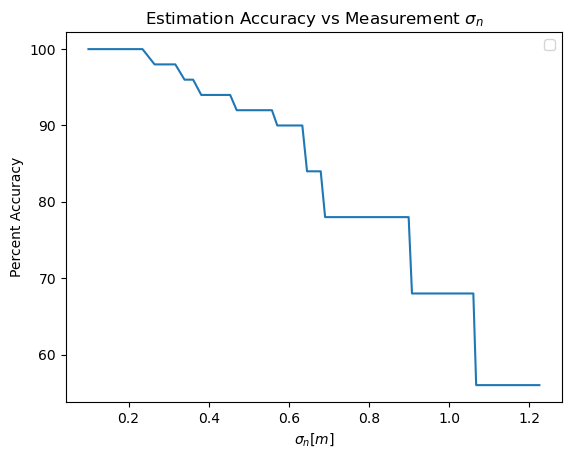

In [413]:
NUM_VARS = 100
var = np.linspace(0.01, 1.5, NUM_VARS)
score = np.zeros(NUM_VARS)

for i in range(NUM_VARS):
    obs = getObservations(x, var[i], NUM_STEPS)
    est = calc_viterbi_estimate(obs, A, pi, var[i], 11, NUM_STEPS)
    num_wrong = np.count_nonzero(est-x)
    score[i] = (NUM_STEPS - num_wrong) * 100 / NUM_STEPS

plot(x_values=np.sqrt(var), y_values=score, title="Estimation Accuracy vs Measurement $\sigma_n$", x_label="$\sigma_n [m]$", y_label="Percent Accuracy")
    

    

This plot clearly shows that at low values of $\sigma_n^2$, the Viterbi estimation remains quite accurate, only dropping below 90% accurate around $\sigma_n^2$ of 0.5 meters. 

# Part 2:
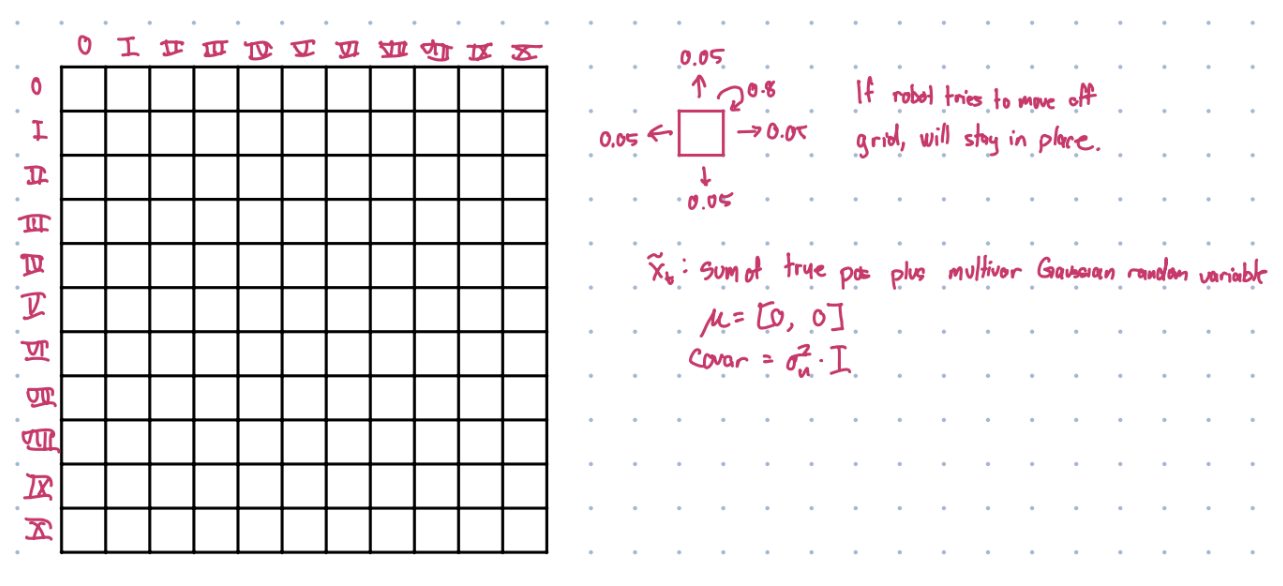

In this example, the robot can be anywhere in 2-Dimensional space. The robot still follows a Markov Model with 121 different states: x = 0, 1, 2, ..., 120
- At edges (not corners):
    - Robot stays in place (P = 0.85)
    - Robot moves to any other available position (P = 0.05)
- At corners:
    - Robot stays in place (P = 0.9)
    - Robot moves to any other available position (P = 0.05)
- At all other valid spaces not previously outlined:
    - Robot stays in place (P = 0.8)
    - Robot moves to any other available position (P = 0.05)

```
Note: The following method for determining the state transition matrix is likely not the most efficient method.

## Part 2(a):
We know that the state transition matrix must have dimensions (121 x 121). First, let's define a function coord_direction() which can convert an input coordinate from the original 2D grid into the corresponding index along the row/column of transition matrix A.

In [414]:
# This is a helper function to make computing A much faster
def coord_direction(coord_org, direction = 4):
    ''' 
    Computes the state index of a position in 2D space.

    Arguments:
    coord_org -- tuple of positional coordinates
    direction -- an integer along [0, 1, 2, 3, 4] which corresponds to the directional [up, right, down, left, original_position]
                 index of 4 means no translation and will return the state index of the provided coord_org

    Returns:
    s_idx -- the state index in the A matrix that corresponds to the desired coord after a designated directional movement
    '''
    row, col = coord_org

    if direction == 0:
        row = row - 1
    if direction == 1:
        col = col + 1
    if direction == 2:
        row = row + 1
    if direction == 3:
        col = col - 1
    
    s_idx = (11*row) + col

    return s_idx

We can create a dictionary of weights, which keeps a record of the directional probabilities for a given 2D position. Additionally, we can record a mapping between the state index and position in 2D space with the function we just created.

In [415]:
# Initialize a weights dictionary that keeps track of the probability in a given direction

weights = {}
state_to_pos = {}

for row in np.arange(11):
    for col in np.arange(11):
        weight = np.array([0.05, 0.05, 0.05, 0.05, 0.80]) # weights = [P(up), P(right), P(down), P(left), P(stay)]

        # Check up
        if row - 1 < 0:
            weight[0] = 0.00
            weight[4] += 0.05

        # Check right
        if col + 1 > 10:
            weight[1] = 0.00
            weight[4] += 0.05

        # Check down
        if row + 1 > 10:
            weight[2] = 0.00
            weight[4] += 0.05

        # Check left
        if col - 1 < 0:
            weight[3] = 0.00
            weight[4] += 0.05

        weights[(row, col)] = weight

        state = coord_direction((row, col))
        state_to_pos[state] = (row, col)

Now we can compute transition matrix A. 
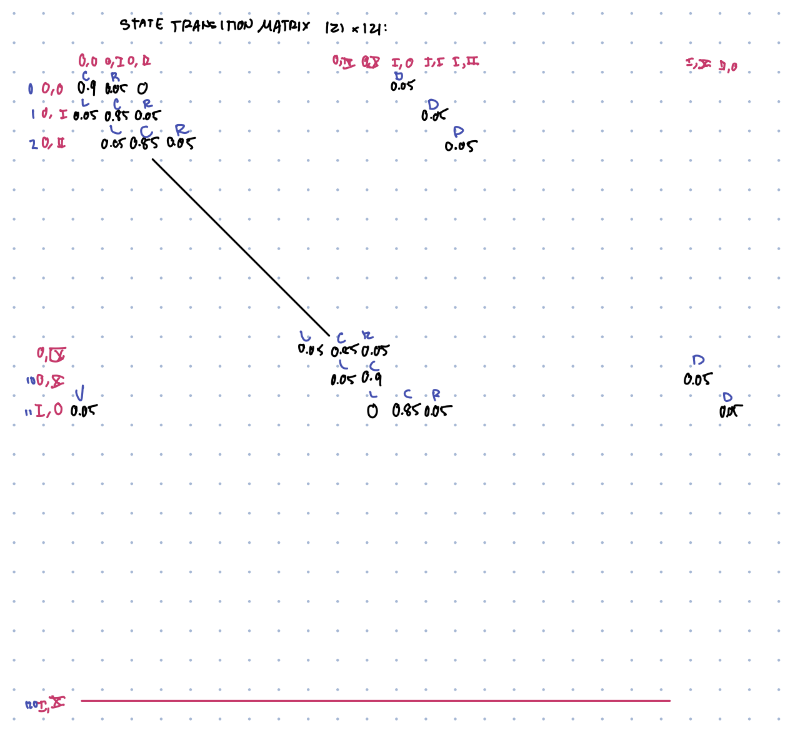
Notice that for a given row:
- The probability of returning to self falls along the diagonal
- The probability of going up/down is 11 indexes to the left/right, respectively
- The probability of going left/right is 1 index to the left/right, respectively

In [416]:
# Initialize transition matrix A
NUM_POS = 121
A = np.zeros((NUM_POS, NUM_POS))


for coord in weights: # Iterate through weights dictionary
    current_index = coord_direction(coord)
    A_col = np.zeros(121)

    # declare directional indices
    up_index = current_index - 11
    right_index = current_index + 1
    down_index = current_index + 11
    left_index = current_index - 1

    directional_indices = [up_index, right_index, down_index, left_index, current_index]

    # Update transition matrix A by row
    for i in range(5):
        if 0 <= directional_indices[i] <= 120:
            A_col[directional_indices[i]] = weights[coord][i]
    
    A[current_index, :] = A_col

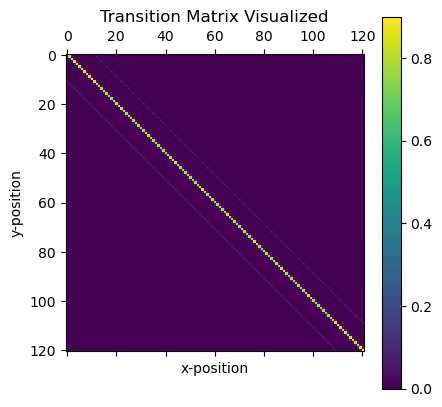

In [417]:
plt.matshow(A)
plt.title("Transition Matrix Visualized")
plt.xlabel("x-position")
plt.ylabel("y-position")
plt.colorbar()
plt.show()

## Part 2(b):
Given a starting position of (5, 5), we will simulate the robot's position over 50 discrete time steps.

In [418]:
# Lets declare the initial PI Matrix where the robot starts at 5, 5
PI_MAT = np.zeros((11, 11))
PI_MAT[5, 5] = 1
PI_MAT = PI_MAT.flatten()

T_1 = PI_MAT@A

In [419]:
# We will store simlation data in this dictionary
# it will have the form int(trial): [array of positional values (from 0, 121)]
positions = {} 
states = np.array(np.arange(121))


for iteration in np.arange(5):
    START_X, START_Y = 5, 5
    PI_INIT = np.zeros((11, 11))
    PI_INIT[START_X, START_Y] = 1
    PI_INIT = PI_INIT.flatten()
    t_next = PI_INIT@A

    positions[iteration+1] = []

    for step in np.arange(50):
        choice = np.random.choice(states, p=t_next)
        pi_next = np.zeros(121)
        pi_next[choice] = 1
        t_next = pi_next@A
        positions[iteration+1].append(choice)


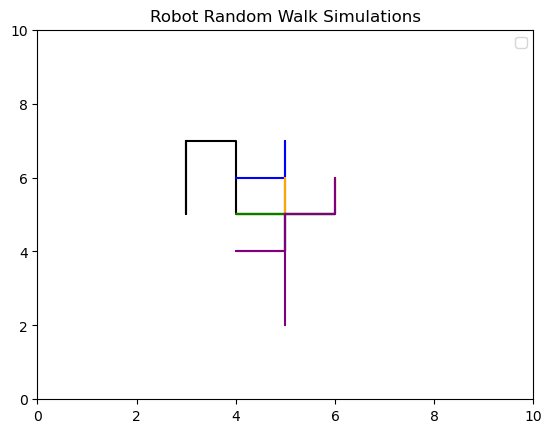

In [420]:
# plotting each simulation
colors = ["black", "blue", "orange", "green", "purple"]

fig, ax = plt.subplots()

for i in np.arange(5):
    x_list, y_list = [], []

    for state_index in positions[i+1]:
        x_next, y_next = state_to_pos[state_index]
        x_list.append(x_next)
        y_list.append(y_next)


    plot(x_list, y_list, x_lim=[0, 10], y_lim=[0, 10], title="Robot Random Walk Simulations", color=colors[i], ax=ax)



## Part 2(c):
We can calculate the PMFs using the same method as described in 1c.

In [421]:
def plot_pmf(steps, title = ""):
    # Lets declare the initial PI Matrix where the robot starts at 5, 5
    PI_MAT = np.zeros((11, 11))
    PI_MAT[5, 5] = 1
    PI_MAT = PI_MAT.flatten()

    T = PI_MAT@(np.linalg.matrix_power(A, steps))
    pmf = np.reshape(T, (11, 11))
    plt.matshow(pmf)

    for (i, j), z in np.ndenumerate(pmf):
        plt.text(j, i, f"{z:.2f}", ha='center', va='center', fontsize='small')

    
    plt.xlabel("x-position")
    plt.ylabel("y-position")
    plt.title(title)
    plt.colorbar()

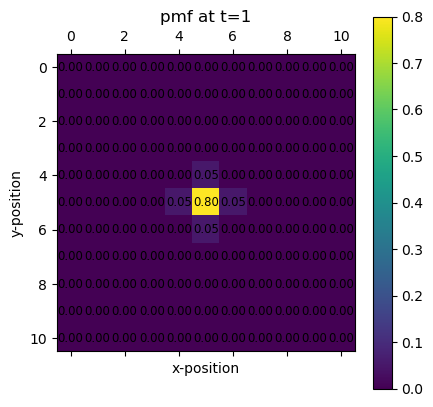

In [422]:
plot_pmf(1, "pmf at t=1")

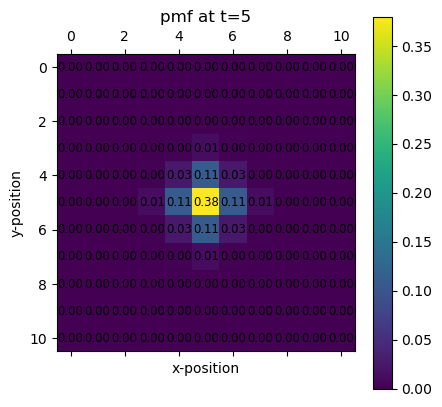

In [423]:
plot_pmf(5, "pmf at t=5")

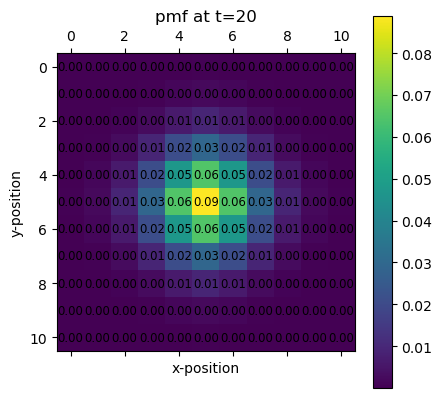

In [424]:
plot_pmf(20, "pmf at t=20")

## Part 2(d):
We can reuse the same function as 1d to compute the simularity here

In [425]:
similarity, pmf = computeCosineSimilarity(100, 121, PI_MAT)

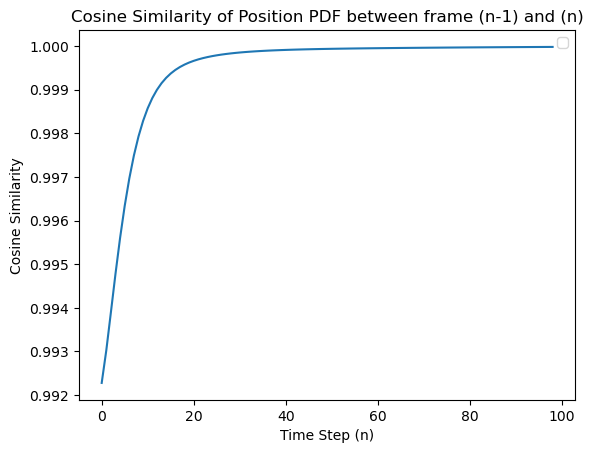

In [426]:
plot(similarity, x_label="Time Step (n)", y_label="Cosine Similarity", title="Cosine Similarity of Position PDF between frame (n-1) and (n)")
plt.show()

## Part 2(e):
We will generate the noisy estimates using similar methods as before

In [427]:
path = np.stack((x_list, y_list), axis=1)
#path # convert the 2-D version of the path into a numpy array

In [428]:
cov = [1, 0.3, 0.05]
paths = {}
covs = {}
for i in range(3):
    cov_mat = np.eye(2)*cov[i]
    path_noisy = getObservations(path, cov_mat, 50, [0, 0])
    paths[i+1] = path_noisy
    covs[i+1] = cov_mat

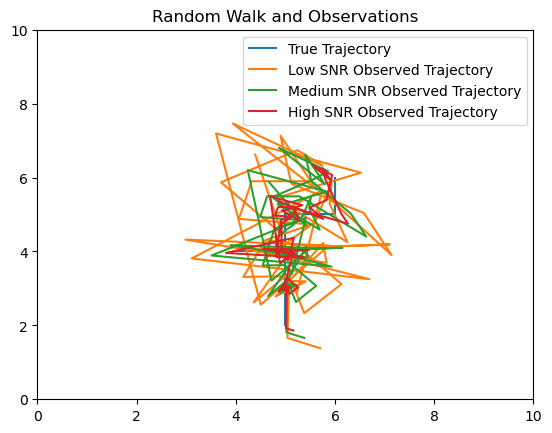

In [429]:
fig, ax = plt.subplots()
plot(path[:, 0], path[:, 1], ax=ax)
plot(paths[1][:, 0], paths[1][:, 1], ax=ax)
plot(paths[2][:, 0], paths[2][:, 1], ax=ax)
plot(paths[3][:, 0], paths[3][:, 1],
     title="Random Walk and Observations",
     legend=["True Trajectory", "Low SNR Observed Trajectory","Medium SNR Observed Trajectory","High SNR Observed Trajectory"],
     x_lim=[0, 10],
     y_lim=[0, 10],
     ax=ax)
plt.show()

## Part 2(f)

In [430]:
def getObservations(x_true, var, num_obs, mu=None):
    # generate  gaussian noise samples
    # set random_state to get the "same" sample pulled from each of the test distributions
    n = multivariate_normal.rvs(mean = mu, cov = var, size = num_obs, random_state = 1) 
    x_tilde_continuous = x_true + n
    x_tilde = np.round(x_tilde_continuous, decimals = 2) # round this so we can easily convert from prob density to true probability later
    return x_tilde

In [431]:
def calcProbMat(obs, num_obs, cov):
    num_states = 121
    p_emit = np.zeros((num_obs, num_states))
    x, y = np.mgrid[0:11, 0:11]
    pos = np.dstack((x, y))

    for i in range(num_obs):
        o = obs[i][:].reshape(2,1)
        for j in range(num_states):
            mean = np.array(state_to_pos[j]).reshape(2,1)
            num = np.exp(-.5*(o-mean).T@np.linalg.inv(cov)@(o-mean))
            pi_d = np.ones((2,2))*np.pi
            denom = np.sqrt(np.pi*np.linalg.det(cov))
            p_emit[i][j] = num/denom
    for i in range(num_obs):
        p_emit[i][:] = p_emit[i][:] / np.sum(p_emit[i][:])
    return p_emit.T



In [432]:
def calc_viterbi_estimate_multi(obs, trans, p_init, cov):
    p_emit = calcProbMat(obs, 50, cov)
    
    # plt.matshow(p_emit)
    path = viterbi(p_emit, trans, p_init = p_init)
    return path

In [433]:
est_lowSNR = calc_viterbi_estimate_multi(paths[1], A, PI_MAT, covs[1])
est_medSNR = calc_viterbi_estimate_multi(paths[2], A, PI_MAT, covs[2])
est_highSNR = calc_viterbi_estimate_multi(paths[3], A, PI_MAT, covs[3])

est_lowSNR = np.array([state_to_pos[i] for i in est_lowSNR])
est_medSNR = np.array([state_to_pos[i] for i in est_medSNR])
est_highSNR = np.array([state_to_pos[i] for i in est_highSNR])

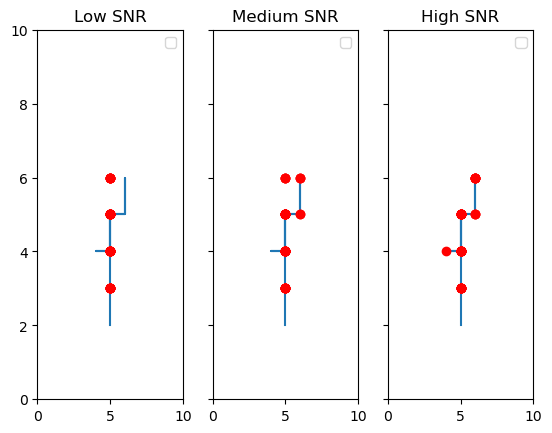

In [434]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3,sharey=True)

plot(path[:, 0], path[:, 1], 
     title="Low SNR",
     x_lim=[0, 10],
     y_lim=[0, 10],
     ax=ax1)
ax1.plot(est_lowSNR[:, 1], est_lowSNR[:, 0], 'o', color='red')

plot(path[:, 0], path[:, 1], 
     title="Medium SNR",
     x_lim=[0, 10],
     y_lim=[0, 10],ax=ax2)
ax2.plot(est_medSNR[:, 1], est_lowSNR[:, 0], 'o', color='red')

plot(path[:, 0], path[:, 1], 
     title="High SNR",
     x_lim=[0, 10],
     y_lim=[0, 10],
     ax=ax3)
ax3.plot(est_highSNR[:, 1], est_lowSNR[:, 0], 'o', color='red')
plt.show()

## Part 2(g)

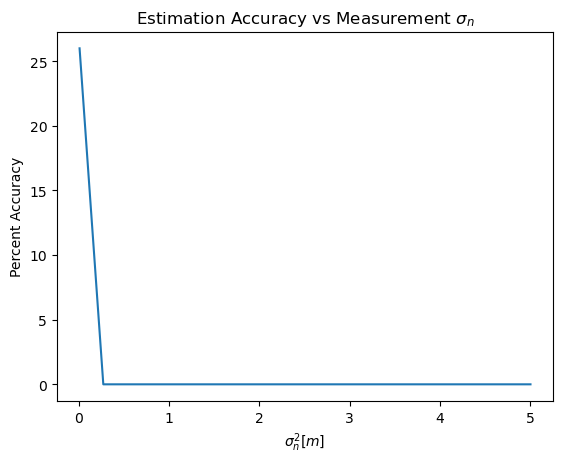

In [435]:
cov_test = np.eye(2)
NUM_VARS = 20
var = np.linspace(0.01, 5, NUM_VARS)
score = np.zeros(NUM_VARS)

num_wrong = np.zeros((NUM_VARS,1))
for i in range(1):
    cov_i = cov_test*var[i]
    guesses = calc_viterbi_estimate_multi(paths[1], A, PI_MAT, cov_i)
    guesses = np.array([state_to_pos[guess] for guess in guesses])

    num_wrong[i] = np.count_nonzero(guesses-path)
    
    score[i] = (NUM_STEPS - num_wrong[i])/NUM_STEPS * 100

plt.plot(var, score)
plt.title("Estimation Accuracy vs Measurement $\sigma_n$")
plt.xlabel("$\sigma_n^2 [m]$")
plt.ylabel("Percent Accuracy")
plt.show()

For the two dimensional state estimation, we see a much lower estimation accuracy at all standard deviations than we did for the single dimensional case. We do see, however, the same trend of a decrease in accuracy at lower SNR values. 